# Zestaw 6

### Kamil Burkiewicz

#### Imports

In [1]:
import math
import numpy as np
from time import time
import matplotlib.pyplot as plt
import random
import string
from pympler import asizeof
import os

In [2]:
# Make notebook wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

#### Actual code

In [3]:
class DBF:
    TERM = chr(0xE000)
    NOT_IN_ALPHABET = chr(0xE001)
    MAX_LEN_IN_STR = 20
    
    def __init__(self, text, build=True):
        self.text = text
        self.names = []
        self.poses = []
        
        # Attribute for an alternative implementation without the necessity 
        # of rebuild for every pattern.
        self.pattern_dict = None

        if (build):
            self.__build()
    
    def __build(self):
        """ Karp-Miller-Rosenberg algorithm for construction of DBF.
        """
        if (len(self.text) == 0):
            return
        elif (len(self.text) == 1):
            factor = 0
        else:
            factor = math.floor(math.log2(len(self.text) - 1))  
        self.text += DBF.TERM * (2**factor - 1)
        if (self.text[-1] != DBF.TERM): self.text += DBF.TERM

        position_to_index, first_entry = self.sort_rename(list(self.text))
        self.names += [position_to_index]
        self.poses += [first_entry]

        power = 1
        for i in range(1, factor + 1):
            new_sequence = []
            prev_names = self.names[i - 1]
            for j in range(len(self.text)):
                if (j + power < len(prev_names)):
                    if (self.pattern_dict is not None):
                        new_sequence += [(prev_names[j], 
                                          prev_names[j + power],
                                          self.text[j : j + power])]
                    else:
                        new_sequence += [(prev_names[j], 
                                          prev_names[j + power])]
            position_to_index, first_entry = self.sort_rename(new_sequence)
            self.names += [position_to_index]
            self.poses += [first_entry]
            power *= 2
        
    def sort_rename(self, sequence):
        """ KMR algorithm helper method.
        """
        last_entry = None
        index = 0
        position_to_index = [None] * len(sequence)
        first_entry = []
        for entry in sorted([(e, i) for i, e in enumerate(sequence)]):
            if (last_entry and last_entry[0] != entry[0]):
                index += 1
                first_entry += [entry[1]]

            position_to_index[entry[1]] = index
            if (self.pattern_dict is not None):
                self.pattern_dict[self.text[
                    entry[1] : entry[1] + 2**(len(self.names))]] = index
                
            if (last_entry is None):
                first_entry += [entry[1]]
            last_entry = entry
    
        return position_to_index, first_entry

    def __str__(self):
        result = "Text:\n" + self.text + "\nNames:\n"
        
        power = 1
        for i in range(len(self.names)):
            result += str(power) + ": " + str(self.names[i]) + "\n"
            power *= 2
            
        result += "\nPositions:\n"
        power = 1
        for i in range(len(self.poses)):
            result += str(power) + ": " + str(self.poses[i]) + "\n"
            power *= 2
        
        if (self.pattern_dict):
            prev_length = 0
            result += "\nDictionary of names for patterns:"
            for key in sorted(self.pattern_dict.keys(), key=len):
                if (len(key) != prev_length):
                    if (prev_length):
                        result += "}"
                    prev_length = len(key)
                    result += f"\nlen={len(key)}: \n" + "{"
                result += f"{key} : {self.pattern_dict[key]}, "
        
        return result + "}\n"
    
    def __repr__(self):
        if (len(self.text) > self.MAX_LEN_IN_STR):
            return f"DBF({self.text[:self.MAX_LEN_IN_STR - 3]})...)"
        return f"DBF({self.text})"
    
    @staticmethod
    def match(text, pattern, verbose=False):
        """ Build new DBF for "pattern&text" and find all occurences of pattern
            in text.
        """
        
        if (len(pattern) > len(text) or not pattern):
            return []
        
        factor_log_len = int(math.log2(len(pattern)))
        dbf = DBF(pattern + DBF.NOT_IN_ALPHABET + text)
        suf_pos = len(pattern) - 2 ** factor_log_len
        factor_names = dbf.names[factor_log_len]
        pre = factor_names[0]
        suf = factor_names[suf_pos]

        result = []
        for i in range(len(pattern), len(factor_names)):
            if (factor_names[i] == pre and factor_names[i + suf_pos] == suf):
                result += [i - len(pattern) - 1]

        if (verbose):
            print(dbf)
        return result, dbf

    def match_no_rebuild(self, pattern):
        """ Match for already built DBF with pattern_dict filled.
        """
        if (not self.pattern_dict):
            raise Exception("This DBF does not store patterns names.")
        
        if (not pattern):
            return []
        
        factor_log_len = int(math.log2(len(pattern)))
        factor_len = 2**factor_log_len
        suf_pos = len(pattern) - factor_len
        pre = pattern[: factor_len]
        suf = pattern[suf_pos :]
        
        if (pre not in self.pattern_dict or suf not in self.pattern_dict):
            return []
        prename = self.pattern_dict[pre]
        sufname = self.pattern_dict[suf]
        
        factor_names = self.names[factor_log_len]
        result = []
        for i in range(self.poses[factor_log_len][prename], len(factor_names)):
            if (factor_names[i] == prename and
                factor_names[i + suf_pos] == sufname):
                result += [i]
        
        return result
    
    @classmethod
    def build_storing_patterns(cls, text):
        """ Alternative DBF build which returns dictionary with names for
            all factors.
        """
        
        # Make DBF object without building dictionary of basic factors stored
        # inside.
        dbf = DBF(text, build=False)
        
        # Set empty pattern dictionary - it will indicate that the dictionary
        # should be filled in __build method call.
        dbf.pattern_dict = {}
        dbf.__build()
        
        return dbf

In [4]:
class SuffixNode:
        def __init__(self, tree, letter=None, suffix_begin=-1, pref_len=-1,
                                                 parent=None, children=None):
            self.letter = '' if not letter else letter
            self._parent = parent  # parent is private due to dynamic calculation of depth 
            self.begin = suffix_begin
            self.len = pref_len  # length of path from the root to the before edge 
            self.children = {} if not children else children
            self.suffix_link = None
            self.tree = tree
            self.depth = 0 if parent is None else parent.depth + 1
        
        @property
        def parent(self):
            return self._parent
        
        @parent.setter
        def parent(self, parent):
            self._parent = parent
            self.depth = parent.depth + 1
        
        def __len__(self):
            return self.len
        
        def add(self, child):
            self.children[child.letter] = child
        
        def __str__(self):
            begin = self.begin + self.parent.len
            end = self.len - self.parent.len + begin
            return self.tree.text[begin : end]
        
        def __lt__(self, other):
            return str(self)[0] < str(other)[0]

In [5]:
class SuffixTree:
    def __init__(self, text=None):
        self.root = SuffixNode(self, suffix_begin=0, pref_len=0)
        self.root.suffix_link = self.root
        self.root.parent = self.root
        self.text = text
    
    @classmethod
    def build_mccreight(cls, text):
        suff_tree = SuffixTree(text)
        suff_tree._is_correct()
        head = suff_tree.root
        text_len = len(text)
        pref_len = 0
        
        for i in range(text_len):
            if (pref_len == len(head) and text[i + pref_len] in head.children):
                head, pref_len = suff_tree._slow_find(i, head, pref_len)
            
            if (len(head) > pref_len):
                head = suff_tree._break_path(head, pref_len)
            suff_tree._create_leaf(i, head, pref_len)
            
            if (head.suffix_link is None):
                suff_tree._fast_find(head, pref_len)
            head = head.suffix_link
            pref_len = len(head)
        
        return suff_tree
    
    @classmethod
    def build_mccreight_slow(cls, text):
        suff_tree = SuffixTree(text)
        suff_tree._is_correct()
        
        head = suff_tree.root
        text_len = len(text)
        pref_len = 0
        
        for i in range(text_len):
            if (pref_len == len(head) and text[i + pref_len] in head.children):
                head, pref_len = suff_tree._slow_find(i, head, pref_len)
            
            if (len(head) > pref_len):
                head = suff_tree._break_path(head, pref_len)
            suff_tree._create_leaf(i, head, pref_len)
            
            pref_len = 0
            head = suff_tree.root
            pref_len = 0
    
        return suff_tree
    
    def _is_correct(self):
        if (self.text is None or self.text is ""):
            raise ValueError("Text is not speccified")
        if (self.text[-1] in self.text[: -1]):
            raise ValueError("Last character is not unique")
    
    def _slow_find(self, cur_begin, head, pref_len):
        while pref_len == len(head) and self.text[cur_begin + pref_len] in head.children:
            head = head.children[self.text[cur_begin + pref_len]]
            pref_len += 1
            while pref_len < len(head) and self.text[cur_begin + pref_len] == self.text[head.begin + pref_len]:
                pref_len += 1
        return head, pref_len
    
    def _break_path(self, node, pref_len):
        parent = node.parent
        new_node = SuffixNode(self, suffix_begin=node.begin, pref_len=pref_len, 
                              letter=self.text[node.begin + len(parent)], parent=parent)
        parent.add(new_node)
        node.parent = new_node
        node.letter = self.text[node.begin + pref_len]
        new_node.add(node)
        
        return new_node
    
    def _create_leaf(self, suffix_begin, head, pref_len):
        leaf = SuffixNode(self, suffix_begin=suffix_begin, pref_len=len(self.text) - suffix_begin,
                          letter=self.text[suffix_begin + pref_len], parent=head)
        head.add(leaf)
        return leaf
    
    def _fast_find(self, head, pref_len):
        next_head = head.parent.suffix_link
        
        while len(next_head) < pref_len - 1:
            next_head = next_head.children[self.text[head.begin + len(next_head) + 1]]
        if len(next_head) > pref_len - 1:
            next_head = self._break_path(next_head, pref_len - 1)
        head.suffix_link = next_head
    
    def __contains__(self, suffix):
        if (suffix is ""): return True
        node = self.root
        
        for depth, letter in enumerate(suffix):
            if (depth == len(node)):
                if (letter not in node.children):
                    return False
                node = node.children[letter]
            elif (letter != self.text[node.begin + depth]):
                return False
        return True

In [6]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while(k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]
        if(pattern[k] == pattern[q]):
            k = k + 1
        pi.append(k)
    return pi

def kmp_string_matching(text, prefix_function, pattern):
    found = []
    q = 0
    for i in range(0, len(text)):
        while(q > 0 and pattern[q] != text[i]):
            q = prefix_function[q-1]
        if(pattern[q] == text[i]):
            q = q + 1
        if(q == len(pattern)):
            found.append(i + 1 - q)
            q = prefix_function[q-1]

    return found

#### Time measurement utils

In [7]:
def timeit(method):
    """ 
    Decorator for measuring time.
    It shows arguments of function.
    """
    MS_IN_S = 1000
    def timed(*args, **kw):
        num_of_meas = 5
        meas = np.empty(num_of_meas)
        
        for i in range(num_of_meas):
            ts = time()
            result = None
            result = method(*args, **kw)
            te = time()
            meas[i] = (te - ts) * MS_IN_S

        # Discard outliers
        meas = meas[abs(meas - np.mean(meas)) < np.std(meas)]
        avg = np.average(meas)
        std = np.std(meas)
        print("%s%23s \t %10.3f ms +/- %2.2f ms" % (method.__name__,
                                        (f"()").ljust(23), avg, std))
        return result, (avg, std)
    return timed

In [21]:
@timeit
def single_build_dbf_meas(text):
    return DBF(text)

def meas_dbf_build(texts_dict):
    meas_time = []
    meas_errs = []
    dbf = None
    for name in texts_dict.keys():
        print(f"Measurement dbf build for\t {name}:")
        dbf, meas = single_build_dbf_meas(texts_dict[name])
        meas_time += [meas[0]]
        meas_errs += [meas[1]]

    return meas_time, meas_errs
    
@timeit
def single_build_suffix_fast_meas(text):
    return SuffixTree.build_mccreight(text)

@timeit
def single_build_suffix_slow_meas(text):
    return SuffixTree.build_mccreight_slow(text)

def meas_suffix_build(texts_dict):
    fast_time = []
    fast_errs = []
    slow_time = []
    slow_errs = []
    suff = None
    for name in texts_dict.keys():
        print(f"Measurement suffix tree build for\t {name}:")
        suff, meas = single_build_suffix_fast_meas(texts_dict[name])
        fast_time += [meas[0]]
        fast_errs += [meas[1]]
        suff, meas = single_build_suffix_slow_meas(texts_dict[name])
        slow_time += [meas[0]]
        slow_errs += [meas[1]]
        
    return (fast_time, fast_errs), (slow_time, slow_errs)

@timeit
def measure_build_dbfs(text):
    return DBF.build_storing_patterns(text)

@timeit
def measure_match_dbfs(dbf, pattern):
    return dbf.match_no_rebuild(pattern)

@timeit
def measure_kmp_build(pattern):
    return prefix_function(pattern)

@timeit
def measure_kmp(text, prefix_function, pattern):
    return kmp_string_matching(text, prefix_function, pattern)

@timeit
def measure_match_dbf(text, pattern):
    return DBF.match(text, pattern)

def compare_KMP_DBF(text, patterns, test_dbfs=True):
    if (test_dbfs):
        print("Measurement of building DBF with memoization:")
        dbfs, dbfs_build_time = measure_build_dbfs(text)
    else:
        dbfs_build_time = None
    dbf_match_time = []
    dbfs_match_time = []
    pref_func_build_time = []
    kmp_time = []
    for pat in patterns:
        print("Mesurement of matching with rebuilding DBF for pat&text:")
        dbf_res, time_meas = measure_match_dbf(text, pat)
        dbf_match_time += [time_meas]
        dbf_res = dbf_res[0]
        
        if (test_dbfs):
            print("Measurement of matching without "
                  "rebuilding DBF (with memoization):")
            dbfs_res, time_meas = measure_match_dbfs(dbfs, pat)
            dbfs_match_time += [time_meas]
        
        print("Measurement of building prefix function for KMP algorithm:")
        pref_fun, time_meas = measure_kmp_build(pat)
        pref_func_build_time += [time_meas]
        print("Measurement of KMP algorithm run:")
        kmp_res, time_meas = measure_kmp(text, pref_fun, pat)
        kmp_time += [time_meas]
        print(f"Are results the same:", end="")
        if (test_dbfs):
            print(f" {sorted(dbf_res) == sorted(kmp_res) == sorted(dbfs_res)}")
        else:
            print(f" {sorted(dbf_res) == sorted(kmp_res)}")
        print()
    
    return (dbfs_build_time, dbf_match_time, dbfs_match_time,
                            pref_func_build_time, kmp_time)

### Tests

#### Some simple tests

In [9]:
text = "sldsfaldsjflkasjdfjaklfjajfkasdfkajsfjakdfjlajflkasdjf\
lajflkjasfajflajskfjalsjdfklajsdklfjaklsdfjlkajsdlkfja\
lksjdfklajslfdjkajsf;ljas;lkfdjaslkfdajsbdfkhfkjhskjaf"
pat = "jas"

print("Occurences with dbf in version pat&text and storing names for patterns:")
print(DBF.match(text, pat)[0])
print(DBF.build_storing_patterns(text).match_no_rebuild(pat))

Occurences with dbf in version pat&text and storing names for patterns:
[60, 130, 138]
[60, 130, 138]


In [10]:
text = "aabaaa"
pat = "aa"
res, dbf = DBF.match(text, pat)
print(f"Dictionary of Basic Factors:\n\n{dbf}")
print(f"Occurences of '{pat}' in '{text}'")
print(res)

Dictionary of Basic Factors:

Text:
aaaabaaa
Names:
1: [0, 0, 3, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
2: [0, 3, 6, 0, 1, 4, 0, 0, 2, 5, 5, 5, 5, 5, 5]
4: [3, 6, 9, 1, 4, 7, 0, 2, 5, 8, 8, 8, 8]
8: [3, 6, 8, 1, 4, 7, 0, 2, 5]

Positions:
1: [0, 5, 9, 2]
2: [0, 4, 8, 1, 5, 9, 2]
4: [6, 3, 7, 0, 4, 8, 1, 5, 9, 2]
8: [6, 3, 7, 0, 4, 8, 1, 5, 2]
}

Occurences of 'aa' in 'aabaaa'
[0, 3, 4]


In [11]:
text = "aabakuklabak"
pat = "bak"

# Here dbf is built
dbf = DBF.build_storing_patterns(text)

print(dbf)
print(f"Occurences of '{pat}' in '{text}'")
print(dbf.match_no_rebuild(pat))

pat = "aba"
print(f"Occurences of '{pat}' in '{text}' (no rebuilt):")
print(dbf.match_no_rebuild(pat))

pat = "akuklabak"
print(f"Occurences of '{pat}' in '{text}' (no rebuilt):")
print(dbf.match_no_rebuild(pat))

Text:
aabakuklabak
Names:
1: [0, 0, 1, 0, 2, 4, 2, 3, 0, 1, 0, 2, 5, 5, 5, 5, 5, 5, 5]
2: [0, 1, 3, 2, 5, 8, 4, 7, 1, 3, 2, 6, 9, 9, 9, 9, 9, 9]
4: [0, 1, 4, 2, 7, 10, 6, 9, 1, 5, 3, 8, 11, 11, 11, 11]
8: [0, 1, 5, 3, 8, 11, 7, 10, 2, 6, 4, 9]

Positions:
1: [0, 2, 4, 7, 5, 12]
2: [0, 1, 3, 2, 6, 4, 11, 7, 5, 12]
4: [0, 1, 3, 10, 2, 9, 6, 4, 11, 7, 5, 12]
8: [0, 1, 8, 3, 10, 2, 9, 6, 4, 11, 7, 5]

Dictionary of names for patterns:
len=1: 
{a : 0, b : 1, k : 2, l : 3, u : 4,  : 5, }
len=2: 
{aa : 0, ab : 1, ak : 2, ba : 3, kl : 4, ku : 5, k : 6, la : 7, uk : 8,  : 9, }
len=4: 
{aaba : 0, abak : 1, akuk : 2, ak : 3, baku : 4, bak : 5, klab : 6, kukl : 7, k : 8, laba : 9, ukla : 10,  : 11, }
len=8: 
{aabakukl : 0, abakukla : 1, abak : 2, akuklaba : 3, ak : 4, bakuklab : 5, bak : 6, klabak : 7, kuklabak : 8, k : 9, labak : 10, uklabak : 11, }

Occurences of 'bak' in 'aabakuklabak'
[2, 9]
Occurences of 'aba' in 'aabakuklabak' (no rebuilt):
[1

In [12]:
with open("1997_714.txt", "r") as f:
    text_1997 = f.read()
with open("romeo-i-julia-700.txt", "r") as f:
    text_romeo = f.read()
with open("zad6", "r") as f:
    text_z6 = f.read()
    
if (text_1997[-1] in text_1997[:-1]): text_1997 += "^"
if (text_romeo[-1] in text_romeo[:-1]): text_romeo += "^"
if (text_z6[-1] in text_z6[:-1]): text_z6 += "^"

print(f"Has text_1997 unique end character: {text_1997[-1] not in text_1997[:-1]}")
print(f"Has text_romeo unique end character: {text_romeo[-1] not in text_romeo[:-1]}")
print(f"Has text_1997 unique end character: {text_z6[-1] not in text_z6[:-1]}")

Has text_1997 unique end character: True
Has text_romeo unique end character: True
Has text_1997 unique end character: True


### Ways of implementing DBF
To omit the rebuilding of DBF for new patterns, we should know the value of Name for the factors of any pattern. The natural choice then is to memoize these factors and appropriate Name values for substrings, that appears in the text. However, we can simply compute, that the space complexity will rise from $O(n\;log(n))$ to $O(n^2)$, where $n$ is the length of text. Indeed, in pessimistic case, all factors will be diferrent and that means we would have to store proportional to $n$ number of strings of lengths being powers of 2 from 1 up to $\frac{n}{2}$ (which we assume to be power of 2 for the sake of simplicity of this analysis), for every lenght of factor. There are $log_2(n) - 1$ such legnths. This gives us:
$$
\sum_{i=1}^{log_2(n) - 1}2^i \cdot n = n \cdot \sum_{i=1}^{log_2(n) - 1}2^i = n \cdot 2 \left(2^{log_2(n) - 1} - 1\right) = 2n\left(\frac{n}{2} - 1\right) = O(n^2).
$$
We can see this result is assymptotically worse than normal DBF, yet I decided to implement this version though.

## Comparison of builds: DBF vs Suffix Tree

In [13]:
texts = {'1997_714.txt' : text_1997,
         'romeo-i-julia-700.txt' : text_romeo,
         'zad6' : text_z6}
dbf_avgs, dbf_errs = meas_dbf_build(texts)
suff_fast_meas, suff_slow_meas = meas_suffix_build(texts)

Measurement dbf build for	 1997_714.txt:
single_build_dbf_meas()                      	  10038.954 ms +/- 99.22 ms
Measurement dbf build for	 romeo-i-julia-700.txt:
single_build_dbf_meas()                      	    243.056 ms +/- 6.35 ms
Measurement dbf build for	 zad6:
single_build_dbf_meas()                      	      9.210 ms +/- 0.16 ms
Measurement suffix tree build for	 1997_714.txt:
single_build_suffix_fast_meas()                      	   2085.477 ms +/- 16.62 ms
single_build_suffix_slow_meas()                      	   4188.234 ms +/- 98.77 ms
Measurement suffix tree build for	 romeo-i-julia-700.txt:
single_build_suffix_fast_meas()                      	     58.573 ms +/- 1.39 ms
single_build_suffix_slow_meas()                      	     71.065 ms +/- 1.55 ms
Measurement suffix tree build for	 zad6:
single_build_suffix_fast_meas()                      	      4.610 ms +/- 0.80 ms
single_build_suffix_slow_meas()                      	      3.576 ms +/- 0.00 ms


In [14]:
print("Sizes of texts:")
print(f"1997_714.txt:\t{len(text_1997)} characters")
print(f"romeo-i-julia-700.txt:\t{len(text_romeo)} characters")
print(f"zad6:\t{len(text_z6)} characters")

lengths = [len(text_1997), len(text_romeo), len(text_z6)]

Sizes of texts:
1997_714.txt:	246473 characters
romeo-i-julia-700.txt:	12651 characters
zad6:	906 characters


<IPython.core.display.Javascript object>


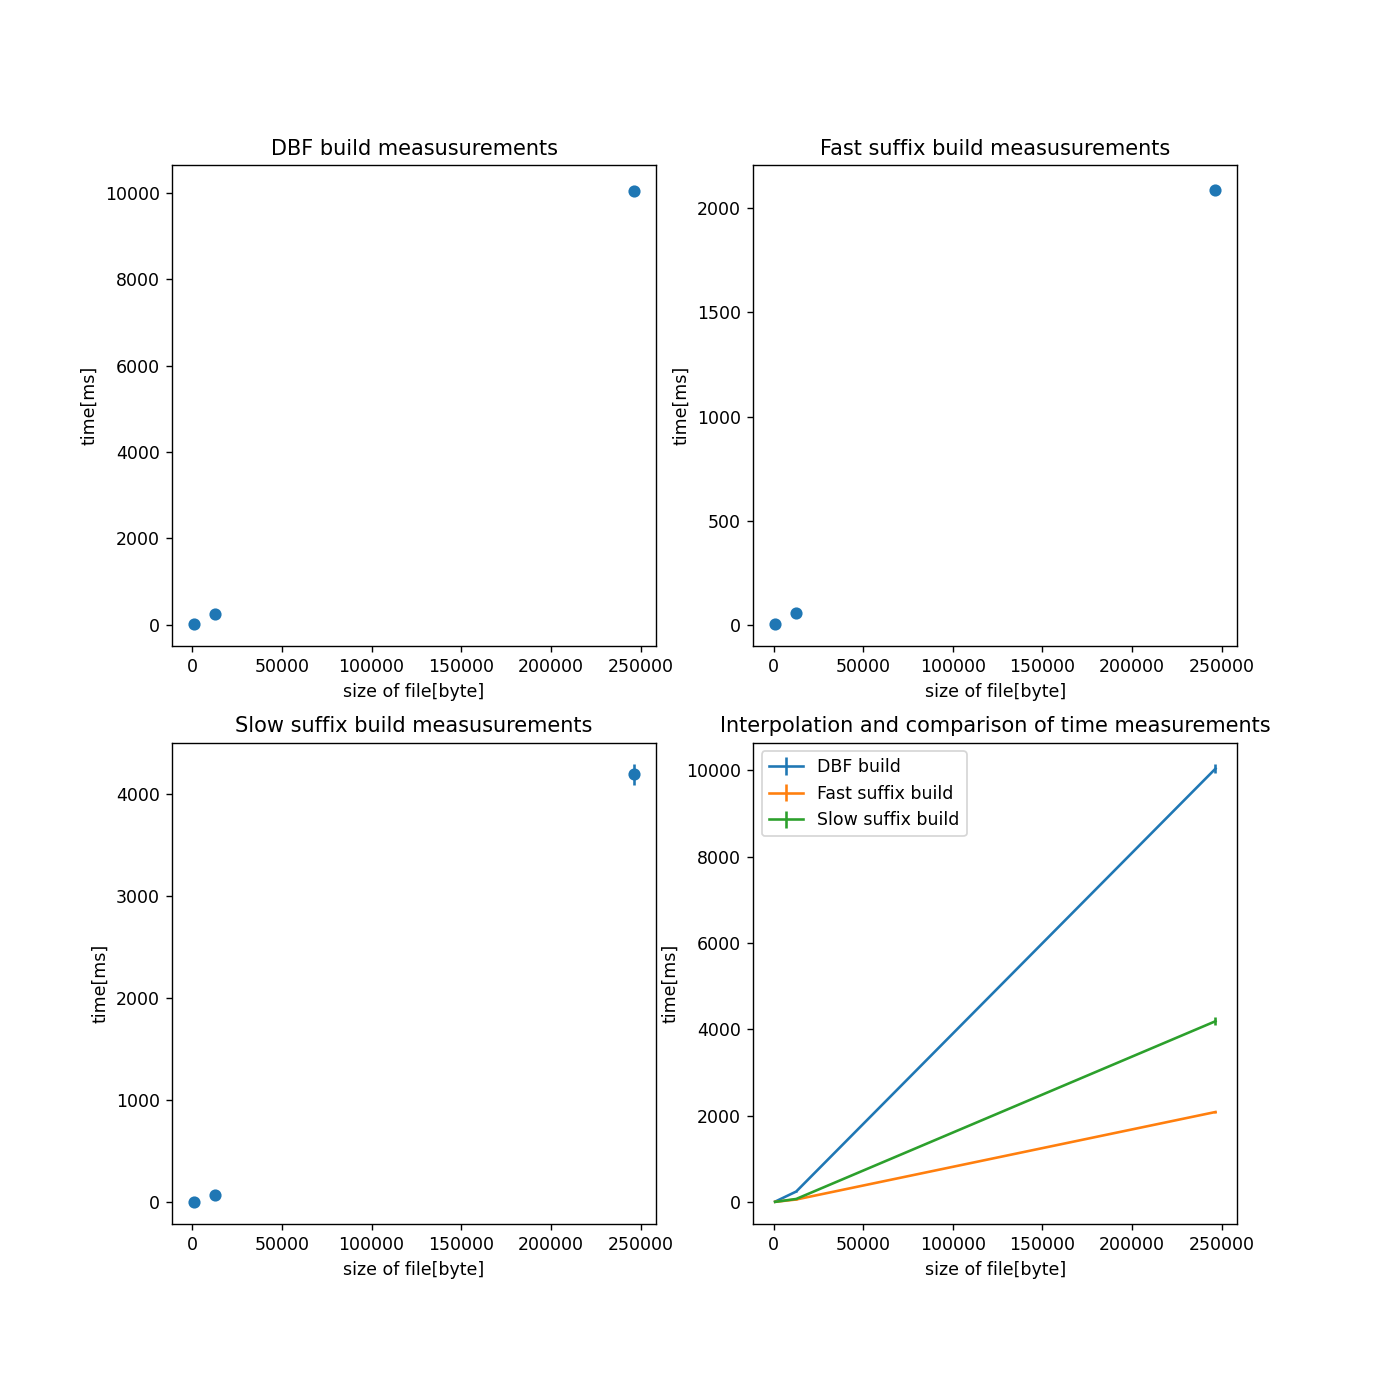

''

In [15]:
%matplotlib notebook
fig, axes = plt.subplots(2, 2, figsize=(11, 11))
axes[0][0].errorbar(lengths, dbf_avgs, yerr=dbf_errs,
                        label='DBF build', fmt='o')
axes[0][0].set(title='DBF build measusurements')
axes[0][1].errorbar(lengths, suff_fast_meas[0], yerr=suff_fast_meas[1],
                         label='Fast suffix build', fmt='o')
axes[0][1].set(title='Fast suffix build measusurements')
axes[1][0].errorbar(lengths, suff_slow_meas[0], yerr=suff_slow_meas[1],
                         label='Slow suffix build', fmt='o')
axes[1][0].set(title='Slow suffix build measusurements')

for row in axes:
    for ax in row:
        ax.set(xlabel='size of file[byte]', ylabel='time[ms]')

dbf_line = axes[1][1].errorbar(lengths, dbf_avgs, yerr=dbf_errs,
                        label='DBF build')
fast_line = axes[1][1].errorbar(lengths, suff_fast_meas[0], yerr=suff_fast_meas[1],
                         label='Fast suffix build')
slow_line = axes[1][1].errorbar(lengths, suff_slow_meas[0], yerr=suff_slow_meas[1],
                         label='Slow suffix build')
axes[1][1].legend(handles=[dbf_line, fast_line, slow_line])
axes[1][1].set(title='Interpolation and comparison of time measurements')
""

In [16]:
plenty_of_random_strings = {str(i * 500 + 1) : "".join(random.choice(string.ascii_lowercase) for
                                    j in range(500 * i)) + '^' for i in range(21)}
lengths = [500 * i + 1 for i in range(21)]

In [17]:
%%capture
# Supress outputs

dbf_avgs, dbf_errs = meas_dbf_build(plenty_of_random_strings)
suff_fast_meas, suff_slow_meas = meas_suffix_build(plenty_of_random_strings)

<IPython.core.display.Javascript object>


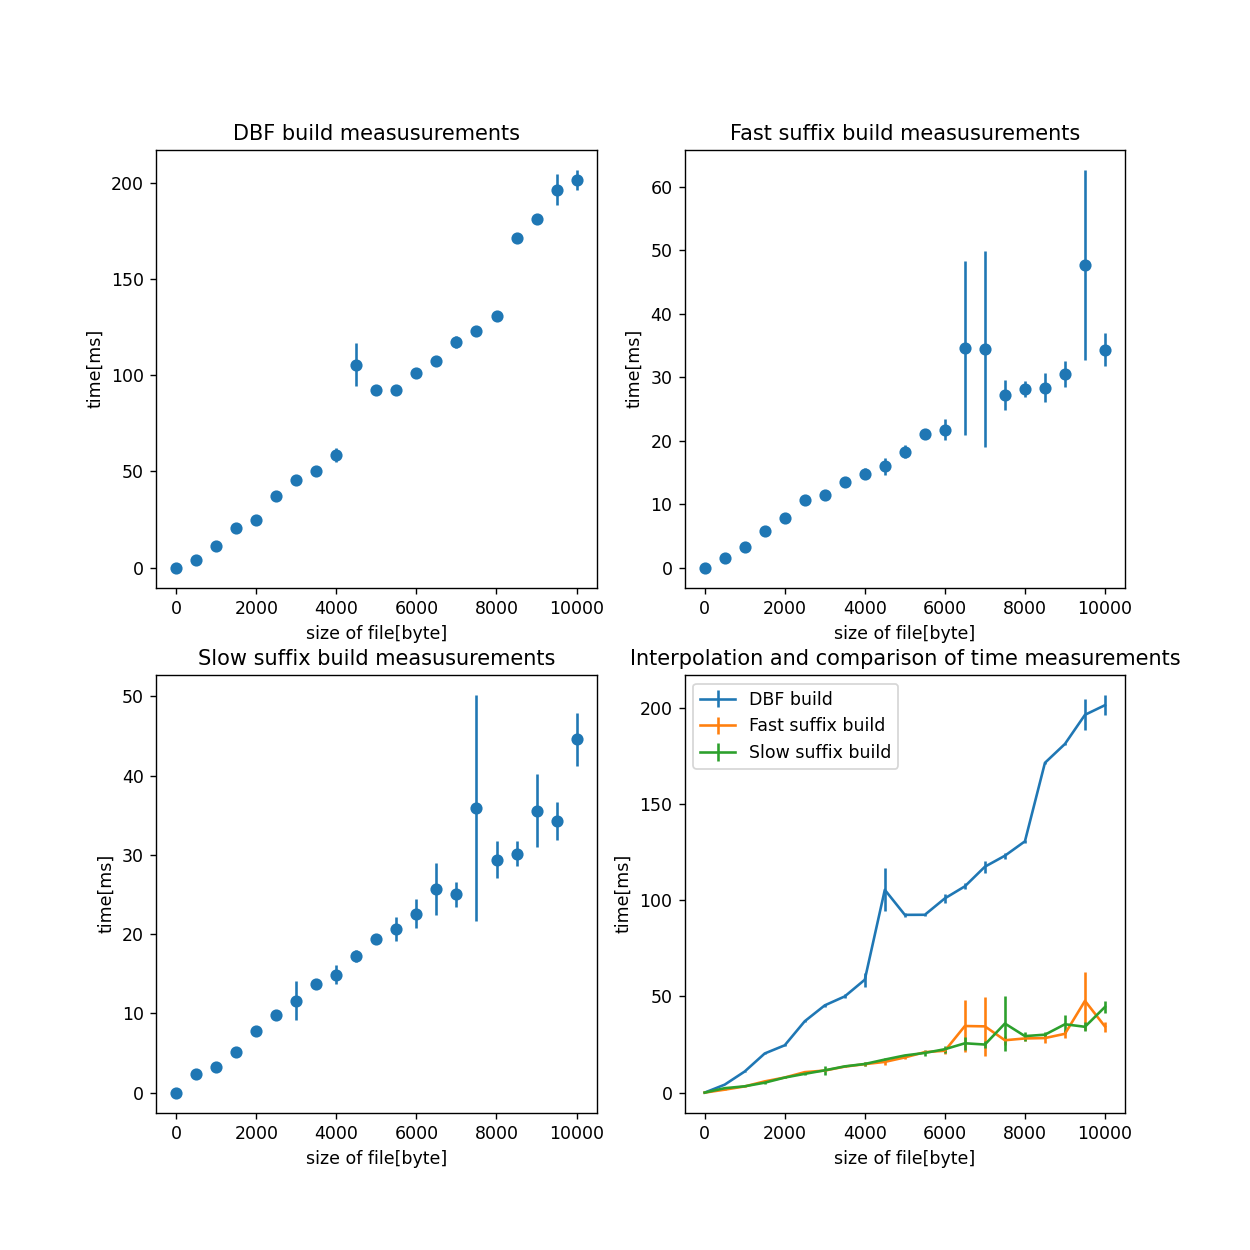

''

In [18]:
%matplotlib notebook

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].errorbar(lengths, dbf_avgs, yerr=dbf_errs,
                        label='DBF build', fmt='o')
axes[0][0].set(title='DBF build measusurements')
axes[0][1].errorbar(lengths, suff_fast_meas[0], yerr=suff_fast_meas[1],
                         label='Fast suffix build', fmt='o')
axes[0][1].set(title='Fast suffix build measusurements')
axes[1][0].errorbar(lengths, suff_slow_meas[0], yerr=suff_slow_meas[1],
                         label='Slow suffix build', fmt='o')
axes[1][0].set(title='Slow suffix build measusurements')

for row in axes:
    for ax in row:
        ax.set(xlabel='size of file[byte]', ylabel='time[ms]')

dbf_line = axes[1][1].errorbar(lengths, dbf_avgs, yerr=dbf_errs,
                        label='DBF build')
fast_line = axes[1][1].errorbar(lengths, suff_fast_meas[0], yerr=suff_fast_meas[1],
                         label='Fast suffix build')
slow_line = axes[1][1].errorbar(lengths, suff_slow_meas[0], yerr=suff_slow_meas[1],
                         label='Slow suffix build')
axes[1][1].legend(handles=[dbf_line, fast_line, slow_line])
axes[1][1].set(title='Interpolation and comparison of time measurements')
""

### Results Commentary
<b>About measurement technique:</b> To perform measurements, time function from time module was used. The idea is to measure time before and after calling function, which builds given structure and the total building time is a difference between these two times.
<br>
<br>
<b>About measurement results:</b> 
We can see, that suffix tree build is much faster than building DBF for the same file sizes. I used 2 ways of building suffix tree - one, which uses only a slow find and one, that uses also a fast find. For such small data set determining any relationships was not possible, so I used more random generated data. From the analysis of graphs one can draw the following conclusions - the complexity of building Suffix Tree is linear and the complexity of building DBF is higher than linear. Theoretical analysis shows that building of DBF can be done in $O(n\;log(n))$ (where $n$ is a size of text), yet here more likely is $O(n\;log^2(n))$, due to the fact that the sorting used to sort_rename is quicksort, whoose average time is $O(n\;log(n))$. It is clear from graphs above, that DBF building is not linear.

## Comparison of sizes: DBF(text) vs text

In [19]:
def size_compare(filename, meas_dbfs=False):
    print(f"Size measurements for file: {filename}")
    
    print(f"\tSize of text: {os.stat(filename).st_size} bytes\n")
    
    with open(filename, "r") as f:
        text = f.read()
        
    dbf = DBF(text)
    print(f"\tDBF size: {asizeof.asized(dbf, detail=1).format()} bytes\n")
    if (meas_dbfs):
        del dbf
        dbfs = DBF.build_storing_patterns(text)
        print(f"\tDBF with pattern memoization: "
              f"{asizeof.asized(dbfs, detail=1).format()} bytes")
    print("\n")

size_compare("1997_714.txt")
size_compare("romeo-i-julia-700.txt", meas_dbfs=True)
size_compare("zad6", meas_dbfs=True)

Size measurements for file: 1997_714.txt
	Size of text: 254133 bytes

	DBF size: DBF(\n\n\n\nDz.U. z 1998 )...) size=297518064 flat=56
    __dict__ size=297518008 flat=112
    __class__ size=0 flat=0 bytes



Size measurements for file: romeo-i-julia-700.txt
	Size of text: 14208 bytes

	DBF size: DBF(William Shakespea)...) size=12586016 flat=56
    __dict__ size=12585960 flat=112
    __class__ size=0 flat=0 bytes

	DBF with pattern memoization: DBF(William Shakespea)...) size=443066456 flat=56
    __dict__ size=443066400 flat=112
    __class__ size=0 flat=0 bytes


Size measurements for file: zad6
	Size of text: 947 bytes

	DBF size: DBF(1. Zaimplementowa)...) size=508616 flat=56
    __dict__ size=508560 flat=112
    __class__ size=0 flat=0 bytes

	DBF with pattern memoization: DBF(1. Zaimplementowa)...) size=3138664 flat=56
    __dict__ size=3138608 flat=112
    __class__ size=0 flat=0 bytes




### Results Commentary
<b>About measurement technique:</b> Measurement of size of file is made by reading an appropriate field of stat structure. Measurement of dbf size is made by functions from asizeof module from Pympler package.
<br>
<br>
<b>About measurement results:</b> 
<br>
    Normal DBF:
<br>
The memory used by DBF is in this implementation is about 
$$
n + 2 \sum_{i=1}^{\lfloor log_2(n - 1)\rfloor} const \cdot length(Names_i) \leq \sum n + 2 \sum_{i=1}^{log_2(n)} const \cdot n = O(n + const \cdot n\;log(n)) = O(n\;log(n)).
$$
This is because we hold in DBF:
- whole text (it is unnecessary, but helps with implementation),
- names and poses tables and they need some constant times some quantity proportional to $n$ memory $log_2(n)$ times for every size of factor, which are powers of 2 from 1 up to n.

After simple computations (due to the size of this data set) I got, that $const \approx 61.25$. This result can be very inaccurate, because of only 3 measurements, but the individual results differed not much.
<br>
<br>
    DBF with memoization of factors:
<br>
The memory used for version with memoization is $O(n^2)$ and this was impossible to measure on my computer for file '1997_714.txt', which is 254133 bytes long (ate about 10GB memory and that was enough to deprive me of all my RAM).
<br>
After simple(due to the size of this data set) computations I obtained, that the constant next to the $n^2$ term is about $3.95$. This result also can be very inaccurate, because of only 2 measurements, but the individual results differed not much.

In [22]:
patterns = ['a', 'konstytucja', '''Zawiadomienie, o którym mowa w ust. 3 pkt 2, może być również złożone
  w tym samym oświadczeniu, w którym podatnik zrzeka się opodatkowania w
  formie ryczałtu od przychodów ewidencjonowanych.''']
print("Measurements of: 1997_714.txt\n")
res = compare_KMP_DBF(text_1997, patterns, test_dbfs=False)
dbfs_build_time_1997 = res[0]
dbf_match_time_1997 = res[1]
dbfs_match_time_1997 = res[2]
pref_func_build_time_1997 = res[3]
kmp_time_1997 = res[4]

patterns = ['a', 'Romeo', 'Mam zwyczaj drapać zaraz, jak mię kto rozrucha.']
print("Measurements of: romeo-i-julia-700.txt\n")
res = compare_KMP_DBF(text_romeo, patterns)
dbfs_build_time_romeo = res[0]
dbf_match_time_romeo = res[1]
dbfs_match_time_romeo = res[2]
pref_func_build_time_romeo = res[3]
kmp_time_romeo = res[4]

patterns = ['a', 'Zaimplementować', 'Rozwiązanie powinno zawierać kod oraz sprawozdanie w formacie PDF lub Jupyter Notebook.']
print("Measurements of: zad6")
res = compare_KMP_DBF(text_z6, patterns)
dbfs_build_time_z6 = res[0]
dbf_match_time_z6 = res[1]
dbfs_match_time_z6 = res[2]
pref_func_build_time_z6 = res[3]
kmp_time_z6 = res[4]

Measurements of: 1997_714.txt

Mesurement of matching with rebuilding DBF for pat&text:
measure_match_dbf()                      	  10687.154 ms +/- 45.34 ms
Measurement of building prefix function for KMP algorithm:
measure_kmp_build()                      	      0.001 ms +/- 0.00 ms
Measurement of KMP algorithm run:
measure_kmp()                      	     31.681 ms +/- 8.16 ms
Are results the same: True

Mesurement of matching with rebuilding DBF for pat&text:
measure_match_dbf()                      	   9790.208 ms +/- 103.85 ms
Measurement of building prefix function for KMP algorithm:
measure_kmp_build()                      	      0.003 ms +/- 0.00 ms
Measurement of KMP algorithm run:
measure_kmp()                      	     24.923 ms +/- 0.09 ms
Are results the same: True

Mesurement of matching with rebuilding DBF for pat&text:
measure_match_dbf()                      	  10094.425 ms +/- 125.87 ms
Measurement of building prefix function for KMP algorithm:
measure_kmp_build()  

<IPython.core.display.Javascript object>


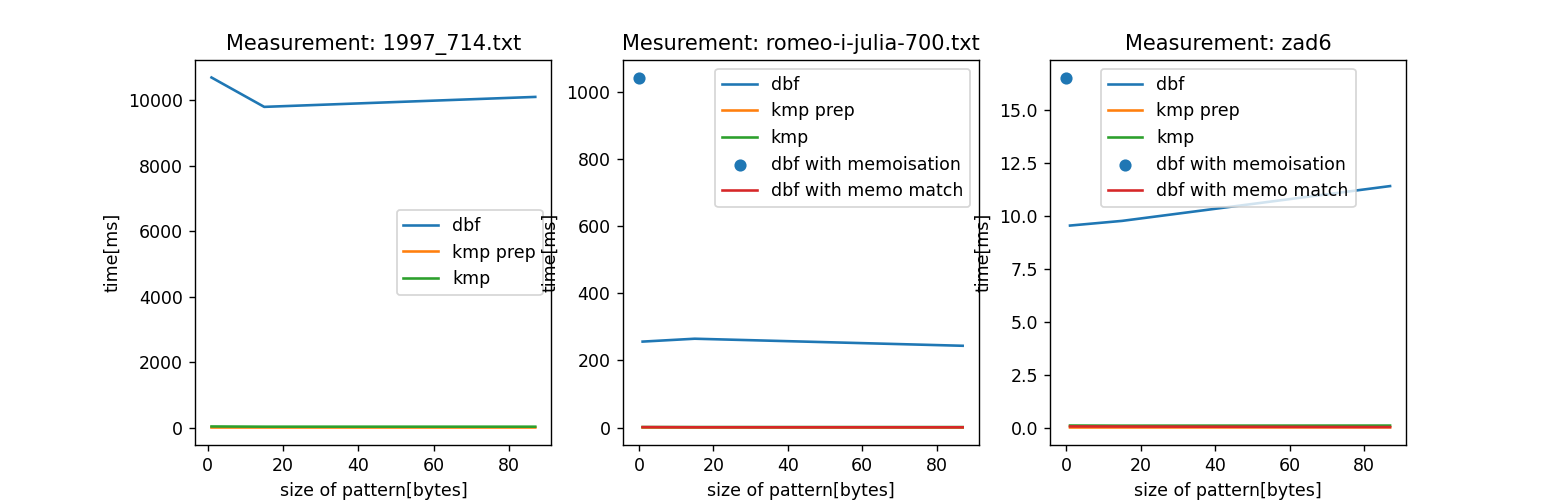

''

In [23]:
%matplotlib notebook
fig, axes = plt.subplots(1, 3, figsize=(12.5, 4))
sizes = list(map(len, patterns))
dbf_line = axes[0].plot(sizes, [meas[0] for meas in dbf_match_time_1997], label='dbf')[0]
kmp_prep_line = axes[0].plot(sizes, [meas[0] for meas in pref_func_build_time_1997], label='kmp prep')[0]
kmp_line = axes[0].plot(sizes, [meas[0] for meas in kmp_time_1997], label='kmp')[0]
axes[0].set(xlabel='size of pattern[bytes]', ylabel='time[ms]', title='Measurement: 1997_714.txt')
axes[0].legend(handles=[dbf_line, kmp_prep_line, kmp_line])

dbf_line = axes[1].plot(sizes, [meas[0] for meas in dbf_match_time_romeo], label='dbf')[0]
kmp_prep_line = axes[1].plot(sizes, [meas[0] for meas in pref_func_build_time_romeo], label='kmp prep')[0]
kmp_line = axes[1].plot(sizes, [meas[0] for meas in kmp_time_romeo], label='kmp')[0]
dbfs_line = axes[1].plot(sizes, [meas[0] for meas in dbfs_match_time_romeo], label='dbf with memo match')[0]
dbfs_sc = axes[1].scatter(0, dbfs_build_time_romeo[0], label='dbf with memoisation')
axes[1].set(xlabel='size of pattern[bytes]', ylabel='time[ms]', title='Mesurement: romeo-i-julia-700.txt')
axes[1].legend(handles=[dbf_line, kmp_prep_line, kmp_line, dbfs_sc, dbfs_line])

dbf_line = axes[2].plot(sizes, [meas[0] for meas in dbf_match_time_z6], label='dbf')[0]
kmp_prep_line = axes[2].plot(sizes, [meas[0] for meas in pref_func_build_time_z6], label='kmp prep')[0]
kmp_line = axes[2].plot(sizes, [meas[0] for meas in kmp_time_z6], label='kmp')[0]
dbfs_line = axes[2].plot(sizes, [meas[0] for meas in dbfs_match_time_z6], label='dbf with memo match')[0]
dbfs_sc = axes[2].scatter(0, dbfs_build_time_z6[0], label='dbf with memoisation')
axes[2].set(xlabel='size of pattern[bytes]', ylabel='time[ms]', title='Measurement: zad6')
axes[2].legend(handles=[dbf_line, kmp_prep_line, kmp_line, dbfs_sc, dbfs_line])
""

### Results Commentary
<b>About measurement technique:</b> Measurement of time the same as in the measuring building time.
<br>
<br>
<b>About measurement results:</b> We can see, that for both of these methods of pattern matching results are not very influenced by size of the pattern, when its size is minor to text size. Also when we want to search for multiple patterns and does not care about memory the use of DBF with memoisation of factors is preffered to normal DBF, because building DBF takes a lot of time. KMP seems the most useful method for this kind of matching, but it theoretically loses to DBF with memoisation when the size of pattern is significant in comparison to the length of text. Practically DBF with memoisation is slightly(very tiny difference) better in graphs above than KMP for big patterns, but is is not statistically significant - the further reasearch is necessary.

#### Bibliography
* [1] Richard M. Karp, Raymond E. Miller, and Arnold L. Rosenberg. 1972. *Rapid identification of repeated patterns in strings, trees and arrays.* In Proceedings of the fourth annual ACM symposium on Theory of computing (STOC '72). Association for Computing Machinery, New York, NY, USA, 125–136.